In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tftables
import time

import model_short as model

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
sess = tf.InteractiveSession()

/home/tey/env/lib/python3.5/site-packages/tensorflow/python/client/session.py:1733: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
def planck(wavelength, T):
    h = 6.626e-34
    c = 3e8
    k = 1.38e-23
    return 2 * h * c**2 / wavelength**5 * 1 / (np.exp(h * c / (wavelength * k * T)) - 1)

In [4]:
def generate_spectrum(T, A, mu, sigma):
    wavelengths = np.linspace(0, 3, num=40001)[1:]
    spectrum = planck(wavelengths * 10**-6, T)
    norm_spectrum = spectrum / np.max(spectrum)
    
    noise = np.random.normal(0, .01, 40000)
    feature = 1 - A * np.exp(-(wavelengths - mu)**2 / 2 / sigma**2)
    return feature * norm_spectrum + noise

In [5]:
def sample_prior():
    T = np.random.uniform(2000, 10000)
    A = np.random.normal(.75, .1)
    mu = np.random.normal(1.5, 1)
    sigma = np.random.normal(.1, .05)
    return T, A, mu, sigma

/home/tey/env/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


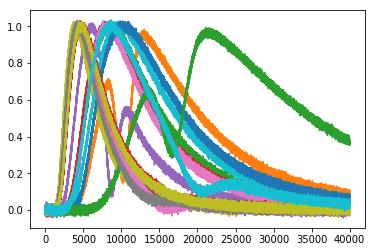

In [6]:
for _ in range(20):
    plt.plot(generate_spectrum(*sample_prior()))

In [7]:
batch_size = 10
n_data = batch_size * 20
data = np.array([generate_spectrum(*sample_prior()) for _ in range(n_data)])[:, :, np.newaxis]
placeholder_data = tf.placeholder(tf.float32, [n_data, 40000, 1])
dataset = tf.data.Dataset.from_tensor_slices(placeholder_data)
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()
d = iterator.get_next()
sess.run(iterator.initializer, feed_dict={placeholder_data: data})

/home/tey/env/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
W0123 21:40:49.445059 140496711755520 deprecation.py:323] From <ipython-input-7-2454db404b45>:7: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


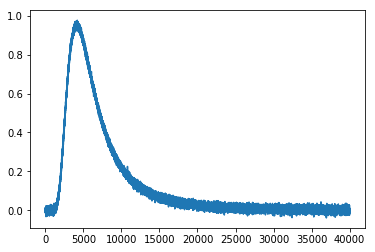

In [8]:
data_init = sess.run(d)
plt.plot(data_init[0])

In [21]:
def input_transform(tbl_batch):
    data = tbl_batch["spectrum"]
    mh_ratio, alpham_ratio = tbl_batch["MH_ratio"], tbl_batch["alphaM_ratio"]
    data_float = tf.to_float(data)
    mh_ratio_float, alpham_ratio_float = tf.to_float(mh_ratio), tf.to_float(alpham_ratio)
    data_slice = data_float[:, 700000:740000] # just a 40000 section of spec
    data_max = tf.reduce_max(data_slice, axis=1)
    normalized_data = tf.divide(data_slice, tf.expand_dims(data_max, axis=1))
    metals = tf.stack([mh_ratio_float, alpham_ratio_float], axis=1)
    return tf.expand_dims(normalized_data, 2), metals

loader = tftables.load_dataset(filename="/mnt/raid0/gabrielc/sample_8k.h5",
                              dataset_path="/spectra",
                              input_transform=input_transform,
                              batch_size=10,
                              cyclic=True,
                              ordered=True)

data_batch, metals_batch = loader.dequeue()

In [22]:
loader.start(sess)

In [23]:
test_data_init = sess.run(data_batch)

In [15]:
test_data_init.shape

(10, 40000)

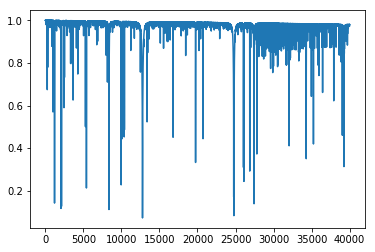

In [24]:
plt.plot(test_data_init[0])

In [25]:
class hps:
    pass
hps.n_levels = 5
hps.n_bins = 2**8
hps.depth = 1
hps.width = 8
hps.train_its = 100 # training iterations
hps.polyak_epochs = 1
hps.beta1 = .1 # learning rate annealing factor
hps.weight_decay = 1 # learning rate annealing factor
hps.lr = .001 # base learning rate
hps.epochs = 100
hps.epochs_warmup = 10
hps.n_train = 20 # batches in an epoch. batch_size * n_train should = number of datapoints
hps.batch_size = 10 # batch size

In [26]:
m = model.model(sess, hps, data_batch, test_data_init)

W0123 21:48:25.268189 140496711755520 deprecation.py:506] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0123 21:48:25.357225 140496711755520 deprecation_wrapper.py:119] From /home/tey/glow/tfops_short.py:102: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



original shape (10, 40000, 1)
encoding z (10, 10000, 4)
creating revnet level 0 (10, 10000, 4)
actnorm_scale (10, 10000, 4) (1, 1, 4) 10000
splitting z (10, 10000, 4)
creating revnet level 1 (10, 5000, 4)
actnorm_scale (10, 5000, 4) (1, 1, 4) 5000
splitting z (10, 5000, 4)
creating revnet level 2 (10, 2500, 4)
actnorm_scale (10, 2500, 4) (1, 1, 4) 2500
splitting z (10, 2500, 4)
creating revnet level 3 (10, 1250, 4)
actnorm_scale (10, 1250, 4) (1, 1, 4) 1250
splitting z (10, 1250, 4)
creating revnet level 4 (10, 625, 4)
actnorm_scale (10, 625, 4) (1, 1, 4) 625
calculating prior (10, 625, 4)


W0123 21:48:27.820497 140496711755520 deprecation.py:323] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/training/moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


original shape (?, 40000, 1)
encoding z (?, 10000, 4)
creating revnet level 0 (?, 10000, 4)
actnorm_scale (?, 10000, 4) (1, 1, 4) 10000
splitting z (?, 10000, 4)
creating revnet level 1 (?, 5000, 4)
actnorm_scale (?, 5000, 4) (1, 1, 4) 5000
splitting z (?, 5000, 4)
creating revnet level 2 (?, 2500, 4)
actnorm_scale (?, 2500, 4) (1, 1, 4) 2500
splitting z (?, 2500, 4)
creating revnet level 3 (?, 1250, 4)
actnorm_scale (?, 1250, 4) (1, 1, 4) 1250
splitting z (?, 1250, 4)
creating revnet level 4 (?, 625, 4)
actnorm_scale (?, 625, 4) (1, 1, 4) 625
calculating prior (?, 625, 4)


In [11]:
%%time
m.train(.001)

CPU times: user 556 ms, sys: 4 ms, total: 560 ms
Wall time: 562 ms


array([-8.0459117e-04, -1.0000000e+00,  0.0000000e+00,  4.9148387e+04,
        4.9148387e+04,  1.3625831e+04,  1.3625831e+04,  2.7115318e+04,
        2.7115318e+04,  1.6488656e+04,  1.6488656e+04,  1.5129487e+04,
        1.5129487e+04,  2.2308203e+01, -1.0000000e+00, -1.5107178e+04],
      dtype=float32)

In [12]:
hps.log

['encoder level 0',
 'revnetstep0post-actnorm',
 'revnetstep0post-1x1conv',
 'end of encoder level 0',
 'encoder level 1',
 'revnetstep0post-actnorm',
 'revnetstep0post-1x1conv',
 'post prior']

In [49]:
n_processed = 0

for epoch in range(1, 1000):
    train_results = []
    sess.run(iterator.initializer, feed_dict={placeholder_data: data})
    epoch_start_time = time.time()
    for iteration in range(10):
        lr = hps.lr * min(1., n_processed / (hps.n_train * hps.epochs_warmup))
        start_time = time.time()
        train_results += [m.train(lr)]
        n_processed += hps.batch_size
        #print(epoch, iteration, np.round(time.time() - start_time, 3), train_results[-1][0])
    print(epoch, np.round(time.time() - epoch_start_time, 3), np.round(np.mean(train_results, axis=0), 3))

1 1.456 [-8.8800001e-01 -1.0000000e+00  0.0000000e+00  6.6256266e+04
  6.6260906e+04  4.5609332e+04  4.5609332e+04  4.3536938e+04
  4.3538445e+04  3.0653760e+04  3.0653760e+04  3.4890777e+04
  3.4891820e+04  2.8915635e+04  2.8915635e+04  3.0217906e+04
  3.0218457e+04  2.7192781e+04  2.7192781e+04  2.7669623e+04
  2.7669906e+04  2.4631508e+04 -1.0000000e+00 -3.0383960e+03]
2 2.227 [-9.7799999e-01 -1.0000000e+00  0.0000000e+00  6.6307633e+04
  6.6358461e+04  4.6327109e+04  4.6327109e+04  4.4273445e+04
  4.4292496e+04  3.2314652e+04  3.2314652e+04  3.6561758e+04
  3.6573707e+04  3.0946969e+04  3.0946969e+04  3.2253797e+04
  3.2260088e+04  2.9430215e+04  2.9430215e+04  2.9909834e+04
  2.9913312e+04  2.7117973e+04 -1.0000000e+00 -2.7953359e+03]
3 2.287 [-1.0030000e+00 -1.0000000e+00  0.0000000e+00  6.6434836e+04
  6.6599609e+04  4.6751367e+04  4.6751367e+04  4.4744793e+04
  4.4806922e+04  3.2899383e+04  3.2899383e+04  3.7171461e+04
  3.7209898e+04  3.1634105e+04  3.1634105e+04  3.2951941e+0

23 2.34 [-2.3789999e+00 -1.0000000e+00  0.0000000e+00  7.1761766e+04
  7.8052922e+04  6.9962391e+04  6.9962391e+04  6.9958039e+04
  7.1964344e+04  6.6189094e+04  6.6189094e+04  7.1342438e+04
  7.2418133e+04  7.0758055e+04  7.0758055e+04  7.2250812e+04
  7.2562586e+04  6.9597250e+04  6.9597250e+04  7.0169062e+04
  7.0290648e+04  6.5956672e+04 -1.0000000e+00 -4.3339922e+03]
24 2.293 [-2.531000e+00 -1.000000e+00  0.000000e+00  7.207260e+04  7.877491e+04
  7.244136e+04  7.244136e+04  7.255611e+04  7.468146e+04  6.977970e+04
  6.977970e+04  7.495010e+04  7.606946e+04  7.450017e+04  7.450017e+04
  7.598500e+04  7.628675e+04  7.381517e+04  7.381517e+04  7.437985e+04
  7.449295e+04  7.017738e+04 -1.000000e+00 -4.315566e+03]
25 2.422 [-2.5620000e+00 -1.0000000e+00  0.0000000e+00  7.2406203e+04
  7.9538477e+04  7.3904891e+04  7.3904891e+04  7.4142680e+04
  7.6385812e+04  7.1452703e+04  7.1452703e+04  7.6634148e+04
  7.7784641e+04  7.6358422e+04  7.6358422e+04  7.7837305e+04
  7.8131234e+04  7.52

45 2.382 [-4.42600012e+00 -1.00000000e+00  0.00000000e+00  7.50702656e+04
  8.51882656e+04  1.15486039e+05  1.15486039e+05  1.16194750e+05
  1.18819703e+05  1.22195227e+05  1.22195227e+05  1.27204148e+05
  1.28167953e+05  1.27327266e+05  1.27327266e+05  1.28769586e+05
  1.28960234e+05  1.26610977e+05  1.26610977e+05  1.27068000e+05
  1.27026938e+05  1.22717859e+05 -1.00000000e+00 -4.30910205e+03]
46 2.45 [-4.7810001e+00 -1.0000000e+00  0.0000000e+00  7.5074422e+04
  8.5196516e+04  1.2004646e+05  1.2004646e+05  1.2075611e+05
  1.2337744e+05  1.2943495e+05  1.2943495e+05  1.3444234e+05
  1.3540203e+05  1.3570458e+05  1.3570458e+05  1.3715052e+05
  1.3734164e+05  1.3555992e+05  1.3555992e+05  1.3601289e+05
  1.3596572e+05  1.3255675e+05 -1.0000000e+00 -3.4089561e+03]
47 2.511 [-4.38600016e+00 -1.00000000e+00  0.00000000e+00  7.50797812e+04
  8.52098828e+04  1.15920828e+05  1.15920828e+05  1.16635000e+05
  1.19257727e+05  1.22170141e+05  1.22170141e+05  1.27176602e+05
  1.28132438e+05  1.2

66 2.613 [-5.0890002e+00 -1.0000000e+00  0.0000000e+00  7.5118086e+04
  8.5282609e+04  1.2665664e+05  1.2665664e+05  1.2734804e+05
  1.2990290e+05  1.3767041e+05  1.3767041e+05  1.4263597e+05
  1.4350372e+05  1.4411161e+05  1.4411161e+05  1.4560658e+05
  1.4581634e+05  1.4415603e+05  1.4415603e+05  1.4455950e+05
  1.4442498e+05  1.4108377e+05 -1.0000000e+00 -3.3412371e+03]
67 2.594 [-4.9920001e+00 -1.0000000e+00  0.0000000e+00  7.5122773e+04
  8.5291062e+04  1.2314254e+05  1.2314254e+05  1.2384035e+05
  1.2640085e+05  1.3458512e+05  1.3458512e+05  1.3955647e+05
  1.4042634e+05  1.4143420e+05  1.4143420e+05  1.4293438e+05
  1.4315027e+05  1.4158047e+05  1.4158047e+05  1.4198412e+05
  1.4185003e+05  1.3841041e+05 -1.0000000e+00 -3.4396001e+03]
68 2.4 [-4.9510002e+00 -1.0000000e+00  0.0000000e+00  7.5127359e+04
  8.5299156e+04  1.2532060e+05  1.2532060e+05  1.2602156e+05
  1.2858446e+05  1.3481322e+05  1.3481322e+05  1.3979000e+05
  1.4066178e+05  1.4083469e+05  1.4083469e+05  1.4234142e+

88 2.298 [-4.8620000e+00 -1.0000000e+00  0.0000000e+00  7.5141539e+04
  8.5315406e+04  1.2289983e+05  1.2289983e+05  1.2358306e+05
  1.2607944e+05  1.3263884e+05  1.3263884e+05  1.3759162e+05
  1.3838761e+05  1.3881145e+05  1.3881145e+05  1.4033066e+05
  1.4054230e+05  1.3866736e+05  1.3866736e+05  1.3905828e+05
  1.3889438e+05  1.3481353e+05 -1.0000000e+00 -4.0808501e+03]
89 2.413 [-5.0799999e+00 -1.0000000e+00  0.0000000e+00  7.5145766e+04
  8.5324922e+04  1.2598708e+05  1.2598708e+05  1.2667431e+05
  1.2917370e+05  1.3729509e+05  1.3729509e+05  1.4224884e+05
  1.4304253e+05  1.4418641e+05  1.4418641e+05  1.4570459e+05
  1.4591442e+05  1.4439972e+05  1.4439972e+05  1.4478625e+05
  1.4461566e+05  1.4085234e+05 -1.0000000e+00 -3.7633420e+03]
90 2.568 [-4.69999981e+00 -1.00000000e+00  0.00000000e+00  7.51431094e+04
  8.53203750e+04  1.16559766e+05  1.16559766e+05  1.17249297e+05
  1.19748875e+05  1.26736000e+05  1.26736000e+05  1.31693031e+05
  1.32487312e+05  1.33287562e+05  1.33287562

110 2.345 [-4.99900007e+00 -1.00000000e+00  0.00000000e+00  7.51546641e+04
  8.53243516e+04  1.22633875e+05  1.22633875e+05  1.23325734e+05
  1.25790266e+05  1.33704875e+05  1.33704875e+05  1.38657156e+05
  1.39414203e+05  1.40885922e+05  1.40885922e+05  1.42414938e+05
  1.42609953e+05  1.41531391e+05  1.41531391e+05  1.41902062e+05
  1.41686844e+05  1.38602297e+05 -1.00000000e+00 -3.08455493e+03]
111 2.597 [-4.71700001e+00 -1.00000000e+00  0.00000000e+00  7.51548438e+04
  8.53227188e+04  1.21960266e+05  1.21960266e+05  1.22649391e+05
  1.25109727e+05  1.30649125e+05  1.30649125e+05  1.35598000e+05
  1.36348766e+05  1.35488656e+05  1.35488656e+05  1.37018859e+05
  1.37214391e+05  1.34703969e+05  1.34703969e+05  1.35077609e+05
  1.34866188e+05  1.30795102e+05 -1.00000000e+00 -4.07107007e+03]
112 2.387 [-4.53100014e+00 -1.00000000e+00  0.00000000e+00  7.51566094e+04
  8.53259609e+04  1.15912375e+05  1.15912375e+05  1.16597773e+05
  1.19052539e+05  1.24030539e+05  1.24030539e+05  1.289686

132 2.35 [-4.80499983e+00 -1.00000000e+00  0.00000000e+00  7.51823750e+04
  8.53368750e+04  1.19870016e+05  1.19870016e+05  1.20559977e+05
  1.22979062e+05  1.30207312e+05  1.30207312e+05  1.35150281e+05
  1.35858656e+05  1.36515422e+05  1.36515422e+05  1.38057875e+05
  1.38241781e+05  1.36885203e+05  1.36885203e+05  1.37253094e+05
  1.37014719e+05  1.33230078e+05 -1.00000000e+00 -3.78466211e+03]
133 2.551 [-4.63600016e+00 -1.00000000e+00  0.00000000e+00  7.51825156e+04
  8.53354844e+04  1.17398625e+05  1.17398625e+05  1.18088484e+05
  1.20506141e+05  1.26747602e+05  1.26747602e+05  1.31686250e+05
  1.32389547e+05  1.32378422e+05  1.32378422e+05  1.33918828e+05
  1.34098938e+05  1.32119922e+05  1.32119922e+05  1.32485906e+05
  1.32242750e+05  1.28542711e+05 -1.00000000e+00 -3.70002393e+03]
134 2.301 [-4.76800013e+00 -1.00000000e+00  0.00000000e+00  7.51761328e+04
  8.53179453e+04  1.15751477e+05  1.15751477e+05  1.16440484e+05
  1.18855750e+05  1.27425914e+05  1.27425914e+05  1.3236551

153 2.323 [-4.9520001e+00 -1.0000000e+00  0.0000000e+00  7.5210859e+04
  8.5378922e+04  1.2413548e+05  1.2413548e+05  1.2483179e+05
  1.2722655e+05  1.3471073e+05  1.3471073e+05  1.3965284e+05
  1.4033014e+05  1.4081441e+05  1.4081441e+05  1.4236997e+05
  1.4254722e+05  1.4112198e+05  1.4112198e+05  1.4150964e+05
  1.4128462e+05  1.3730556e+05 -1.0000000e+00 -3.9790720e+03]
154 2.227 [-4.9320002e+00 -1.0000000e+00  0.0000000e+00  7.5213305e+04
  8.5384102e+04  1.2238655e+05  1.2238655e+05  1.2308231e+05
  1.2547492e+05  1.3378447e+05  1.3378447e+05  1.3872364e+05
  1.3939542e+05  1.4020247e+05  1.4020247e+05  1.4175375e+05
  1.4192516e+05  1.4031891e+05  1.4031891e+05  1.4070323e+05
  1.4047428e+05  1.3675606e+05 -1.0000000e+00 -3.7182209e+03]
155 2.28 [-5.4369998e+00 -1.0000000e+00  0.0000000e+00  7.5212016e+04
  8.5379602e+04  1.3163872e+05  1.3163872e+05  1.3233552e+05
  1.3472758e+05  1.4554553e+05  1.4554553e+05  1.5048283e+05
  1.5115045e+05  1.5303866e+05  1.5303866e+05  1.54588

175 2.367 [-4.72300005e+00 -1.00000000e+00  0.00000000e+00  7.52305703e+04
  8.54012891e+04  1.16682688e+05  1.16682688e+05  1.17388812e+05
  1.19769938e+05  1.27559797e+05  1.27559797e+05  1.32504359e+05
  1.33154906e+05  1.34083391e+05  1.34083391e+05  1.35646906e+05
  1.35817375e+05  1.34640469e+05  1.34640469e+05  1.35039141e+05
  1.34816578e+05  1.30941516e+05 -1.00000000e+00 -3.87505811e+03]
176 2.348 [-4.9219999e+00 -1.0000000e+00  0.0000000e+00  7.5230547e+04
  8.5398664e+04  1.2299389e+05  1.2299389e+05  1.2369970e+05
  1.2607904e+05  1.3394394e+05  1.3394394e+05  1.3888536e+05
  1.3953239e+05  1.3990966e+05  1.3990966e+05  1.4146994e+05
  1.4163592e+05  1.4020656e+05  1.4020656e+05  1.4060122e+05
  1.4037138e+05  1.3645658e+05 -1.0000000e+00 -3.9148101e+03]
177 2.374 [-4.91800022e+00 -1.00000000e+00  0.00000000e+00  7.52333750e+04
  8.54039141e+04  1.20646453e+05  1.20646453e+05  1.21352398e+05
  1.23730336e+05  1.33145000e+05  1.33145000e+05  1.38081969e+05
  1.38722344e+05 

196 2.246 [-5.2649999e+00 -1.0000000e+00  0.0000000e+00  7.5250984e+04
  8.5419203e+04  1.2521348e+05  1.2521348e+05  1.2591980e+05
  1.2828064e+05  1.3983914e+05  1.3983914e+05  1.4476716e+05
  1.4538145e+05  1.4780362e+05  1.4780362e+05  1.4936175e+05
  1.4951362e+05  1.4898209e+05  1.4898209e+05  1.4936912e+05
  1.4911364e+05  1.4598314e+05 -1.0000000e+00 -3.1304990e+03]
197 2.269 [-5.5599999e+00 -1.0000000e+00  0.0000000e+00  7.5255484e+04
  8.5430750e+04  1.3258784e+05  1.3258784e+05  1.3329828e+05
  1.3566394e+05  1.4810262e+05  1.4810262e+05  1.5303903e+05
  1.5365877e+05  1.5616866e+05  1.5616866e+05  1.5773209e+05
  1.5788966e+05  1.5735572e+05  1.5735572e+05  1.5774597e+05
  1.5749509e+05  1.5416384e+05 -1.0000000e+00 -3.3312390e+03]
198 2.33 [-4.7849998e+00 -1.0000000e+00  0.0000000e+00  7.5259062e+04
  8.5439820e+04  1.2009011e+05  1.2009011e+05  1.2080192e+05
  1.2316927e+05  1.3133072e+05  1.3133072e+05  1.3627056e+05
  1.3689000e+05  1.3704270e+05  1.3704270e+05  1.38609

218 2.286 [-4.8620000e+00 -1.0000000e+00  0.0000000e+00  7.5264891e+04
  8.5434992e+04  1.2173204e+05  1.2173204e+05  1.2243325e+05
  1.2477205e+05  1.3217211e+05  1.3217211e+05  1.3708805e+05
  1.3766353e+05  1.3778611e+05  1.3778611e+05  1.3935072e+05
  1.3948798e+05  1.3813172e+05  1.3813172e+05  1.3850966e+05
  1.3822809e+05  1.3481634e+05 -1.0000000e+00 -3.4117690e+03]
219 2.351 [-4.9340000e+00 -1.0000000e+00  0.0000000e+00  7.5262070e+04
  8.5428922e+04  1.2298085e+05  1.2298085e+05  1.2367996e+05
  1.2601523e+05  1.3417309e+05  1.3417309e+05  1.3908480e+05
  1.3965530e+05  1.4008723e+05  1.4008723e+05  1.4165003e+05
  1.4178466e+05  1.4053480e+05  1.4053480e+05  1.4091228e+05
  1.4063038e+05  1.3681216e+05 -1.0000000e+00 -3.8182219e+03]
220 2.576 [-5.3499999e+00 -1.0000000e+00  0.0000000e+00  7.5264797e+04
  8.5436523e+04  1.2839252e+05  1.2839252e+05  1.2909321e+05
  1.3142947e+05  1.4316916e+05  1.4316916e+05  1.4808316e+05
  1.4865512e+05  1.5053791e+05  1.5053791e+05  1.5210

240 2.458 [-5.5029998e+00 -1.0000000e+00  0.0000000e+00  7.5271039e+04
  8.5436227e+04  1.3278898e+05  1.3278898e+05  1.3349172e+05
  1.3581930e+05  1.4732784e+05  1.4732784e+05  1.5226389e+05
  1.5283350e+05  1.5466741e+05  1.5466741e+05  1.5624795e+05
  1.5638609e+05  1.5582133e+05  1.5582133e+05  1.5622580e+05
  1.5597355e+05  1.5258723e+05 -1.0000000e+00 -3.3863130e+03]
241 2.452 [-5.2789998e+00 -1.0000000e+00  0.0000000e+00  7.5274695e+04
  8.5447195e+04  1.2989110e+05  1.2989110e+05  1.3059435e+05
  1.3292189e+05  1.4274025e+05  1.4274025e+05  1.4767478e+05
  1.4824278e+05  1.4917516e+05  1.4917516e+05  1.5075581e+05
  1.5089378e+05  1.4987319e+05  1.4987319e+05  1.5027984e+05
  1.5003005e+05  1.4635920e+05 -1.0000000e+00 -3.6708530e+03]
242 2.73 [-5.1550002e+00 -1.0000000e+00  0.0000000e+00  7.5276891e+04
  8.5453320e+04  1.2569098e+05  1.2569098e+05  1.2639335e+05
  1.2871886e+05  1.3854670e+05  1.3854670e+05  1.4347641e+05
  1.4403939e+05  1.4545316e+05  1.4545316e+05  1.47030

262 2.372 [-5.4879999e+00 -1.0000000e+00  0.0000000e+00  7.5290461e+04
  8.5474336e+04  1.3174922e+05  1.3174922e+05  1.3245770e+05
  1.3477711e+05  1.4685402e+05  1.4685402e+05  1.5179047e+05
  1.5234589e+05  1.5451020e+05  1.5451020e+05  1.5608866e+05
  1.5621414e+05  1.5568541e+05  1.5568541e+05  1.5608441e+05
  1.5581081e+05  1.5216791e+05 -1.0000000e+00 -3.6429121e+03]
263 2.484 [-4.7919998e+00 -1.0000000e+00  0.0000000e+00  7.5289242e+04
  8.5471961e+04  1.1928917e+05  1.1928917e+05  1.1999630e+05
  1.2231339e+05  1.2980598e+05  1.2980598e+05  1.3473852e+05
  1.3528966e+05  1.3579612e+05  1.3579612e+05  1.3737231e+05
  1.3749461e+05  1.3633528e+05  1.3633528e+05  1.3673161e+05
  1.3645453e+05  1.3285072e+05 -1.0000000e+00 -3.6038130e+03]
264 2.575 [-5.25899982e+00 -1.00000000e+00  0.00000000e+00  7.52860469e+04
  8.54612031e+04  1.30789414e+05  1.30789414e+05  1.31493844e+05
  1.33806734e+05  1.42883281e+05  1.42883281e+05  1.47811500e+05
  1.48358266e+05  1.48783406e+05  1.48783

284 2.535 [-5.12599993e+00 -1.00000000e+00  0.00000000e+00  7.52947969e+04
  8.54846406e+04  1.25915125e+05  1.25915125e+05  1.26617172e+05
  1.28916102e+05  1.38436406e+05  1.38436406e+05  1.43360766e+05
  1.43890156e+05  1.44967328e+05  1.44967328e+05  1.46547688e+05
  1.46658797e+05  1.45760500e+05  1.45760500e+05  1.46154375e+05
  1.45866766e+05  1.42136016e+05 -1.00000000e+00 -3.73075806e+03]
285 2.489 [-5.2509999e+00 -1.0000000e+00  0.0000000e+00  7.5291094e+04
  8.5472711e+04  1.2780021e+05  1.2780021e+05  1.2849727e+05
  1.3078952e+05  1.4120664e+05  1.4120664e+05  1.4612342e+05
  1.4664489e+05  1.4791398e+05  1.4791398e+05  1.4948952e+05
  1.4959516e+05  1.4892258e+05  1.4892258e+05  1.4931528e+05
  1.4902722e+05  1.4559423e+05 -1.0000000e+00 -3.4330061e+03]
286 2.396 [-5.1420002e+00 -1.0000000e+00  0.0000000e+00  7.5292469e+04
  8.5475539e+04  1.2777208e+05  1.2777208e+05  1.2846820e+05
  1.3075881e+05  1.3977909e+05  1.3977909e+05  1.4469334e+05
  1.4521044e+05  1.4574745e+0

306 2.567 [-5.5749998e+00 -1.0000000e+00  0.0000000e+00  7.5302406e+04
  8.5492242e+04  1.3447269e+05  1.3447269e+05  1.3517145e+05
  1.3745381e+05  1.4951384e+05  1.4951384e+05  1.5443838e+05
  1.5495122e+05  1.5680738e+05  1.5680738e+05  1.5839209e+05
  1.5849295e+05  1.5789491e+05  1.5789491e+05  1.5829245e+05
  1.5800605e+05  1.5456225e+05 -1.0000000e+00 -3.4438149e+03]
307 2.328 [-5.0689998e+00 -1.0000000e+00  0.0000000e+00  7.5302922e+04
  8.5493562e+04  1.2473167e+05  1.2473167e+05  1.2542952e+05
  1.2771015e+05  1.3738105e+05  1.3738105e+05  1.4230175e+05
  1.4280997e+05  1.4356634e+05  1.4356634e+05  1.4514806e+05
  1.4524455e+05  1.4415775e+05  1.4415775e+05  1.4455591e+05
  1.4426991e+05  1.4054028e+05 -1.0000000e+00 -3.7296140e+03]
308 2.31 [-5.14200020e+00 -1.00000000e+00  0.00000000e+00  7.53010391e+04
  8.54852578e+04  1.25142516e+05  1.25142516e+05  1.25837797e+05
  1.28114797e+05  1.38273156e+05  1.38273156e+05  1.43186172e+05
  1.43684578e+05  1.45195844e+05  1.451958

328 2.297 [-5.7459998e+00 -1.0000000e+00  0.0000000e+00  7.5298078e+04
  8.5466805e+04  1.3695339e+05  1.3695339e+05  1.3765028e+05
  1.3991823e+05  1.5313267e+05  1.5313267e+05  1.5804928e+05
  1.5853862e+05  1.6103778e+05  1.6103778e+05  1.6261805e+05
  1.6270130e+05  1.6249541e+05  1.6249541e+05  1.6290155e+05
  1.6262448e+05  1.5930598e+05 -1.0000000e+00 -3.3184939e+03]
329 2.296 [-5.2700000e+00 -1.0000000e+00  0.0000000e+00  7.5302336e+04
  8.5476734e+04  1.2885190e+05  1.2885190e+05  1.2955102e+05
  1.3182136e+05  1.4253014e+05  1.4253014e+05  1.4744766e+05
  1.4793733e+05  1.4910361e+05  1.4910361e+05  1.5068395e+05
  1.5076702e+05  1.4990509e+05  1.4990509e+05  1.5031061e+05
  1.5003158e+05  1.4611331e+05 -1.0000000e+00 -3.9182661e+03]
330 2.335 [-5.4990001e+00 -1.0000000e+00  0.0000000e+00  7.5305648e+04
  8.5484117e+04  1.3267017e+05  1.3267017e+05  1.3336972e+05
  1.3563970e+05  1.4750475e+05  1.4750475e+05  1.5241991e+05
  1.5290695e+05  1.5487959e+05  1.5487959e+05  1.5645

350 2.288 [-5.5920000e+00 -1.0000000e+00  0.0000000e+00  7.5321133e+04
  8.5503602e+04  1.3446716e+05  1.3446716e+05  1.3516541e+05
  1.3742545e+05  1.4991166e+05  1.4991166e+05  1.5481123e+05
  1.5527894e+05  1.5746822e+05  1.5746822e+05  1.5903861e+05
  1.5910166e+05  1.5863252e+05  1.5863252e+05  1.5901903e+05
  1.5870452e+05  1.5504220e+05 -1.0000000e+00 -3.6622959e+03]
351 2.298 [-5.25299978e+00 -1.00000000e+00  0.00000000e+00  7.53239844e+04
  8.55051094e+04  1.26691375e+05  1.26691375e+05  1.27389797e+05
  1.29649359e+05  1.40282797e+05  1.40282797e+05  1.45182812e+05
  1.45650641e+05  1.47840203e+05  1.47840203e+05  1.49410156e+05
  1.49472250e+05  1.49000344e+05  1.49000344e+05  1.49386828e+05
  1.49073344e+05  1.45637406e+05 -1.00000000e+00 -3.43593091e+03]
352 2.441 [-5.3080001e+00 -1.0000000e+00  0.0000000e+00  7.5323234e+04
  8.5501422e+04  1.2741692e+05  1.2741692e+05  1.2811596e+05
  1.3037583e+05  1.4182478e+05  1.4182478e+05  1.4672927e+05
  1.4720045e+05  1.4929961e+0

371 2.397 [-5.21199989e+00 -1.00000000e+00  0.00000000e+00  7.53246719e+04
  8.54863828e+04  1.23945914e+05  1.23945914e+05  1.24637172e+05
  1.26879203e+05  1.38352688e+05  1.38352688e+05  1.43248891e+05
  1.43702812e+05  1.46430281e+05  1.46430281e+05  1.48001469e+05
  1.48053875e+05  1.47914312e+05  1.47914312e+05  1.48298531e+05
  1.47978078e+05  1.44509469e+05 -1.00000000e+00 -3.46859204e+03]
372 2.407 [-5.7480001e+00 -1.0000000e+00  0.0000000e+00  7.5324516e+04
  8.5484430e+04  1.3610480e+05  1.3610480e+05  1.3679616e+05
  1.3903805e+05  1.5266936e+05  1.5266936e+05  1.5756683e+05
  1.5802186e+05  1.6093448e+05  1.6093448e+05  1.6250695e+05
  1.6256072e+05  1.6252319e+05  1.6252319e+05  1.6290948e+05
  1.6259244e+05  1.5935616e+05 -1.0000000e+00 -3.2362900e+03]
373 2.421 [-5.6100001e+00 -1.0000000e+00  0.0000000e+00  7.5327898e+04
  8.5492602e+04  1.3534859e+05  1.3534859e+05  1.3604139e+05
  1.3828481e+05  1.5067341e+05  1.5067341e+05  1.5557180e+05
  1.5602712e+05  1.5807969e+0

393 2.356 [-5.3820000e+00 -1.0000000e+00  0.0000000e+00  7.5343734e+04
  8.5518430e+04  1.2680423e+05  1.2680423e+05  1.2749927e+05
  1.2973777e+05  1.4211603e+05  1.4211603e+05  1.4701086e+05
  1.4745273e+05  1.5075141e+05  1.5075141e+05  1.5232328e+05
  1.5236780e+05  1.5241873e+05  1.5241873e+05  1.5282041e+05
  1.5252608e+05  1.4922681e+05 -1.0000000e+00 -3.2992720e+03]
394 2.519 [-5.5019999e+00 -1.0000000e+00  0.0000000e+00  7.5344516e+04
  8.5519844e+04  1.3404923e+05  1.3404923e+05  1.3474438e+05
  1.3698270e+05  1.4847811e+05  1.4847811e+05  1.5337392e+05
  1.5381683e+05  1.5529597e+05  1.5529597e+05  1.5686791e+05
  1.5691181e+05  1.5614884e+05  1.5614884e+05  1.5654966e+05
  1.5625386e+05  1.5254030e+05 -1.0000000e+00 -3.7135601e+03]
395 2.466 [-5.8909998e+00 -1.0000000e+00  0.0000000e+00  7.5346594e+04
  8.5525984e+04  1.3957898e+05  1.3957898e+05  1.4027366e+05
  1.4251078e+05  1.5674053e+05  1.5674053e+05  1.6163239e+05
  1.6207153e+05  1.6492191e+05  1.6492191e+05  1.6649

415 2.311 [-4.61199999e+00 -1.00000000e+00  0.00000000e+00  7.53382031e+04
  8.55138281e+04  1.08972141e+05  1.08972141e+05  1.09666188e+05
  1.11894148e+05  1.22180711e+05  1.22180711e+05  1.27078227e+05
  1.27518289e+05  1.30059414e+05  1.30059414e+05  1.31629750e+05
  1.31665547e+05  1.31388531e+05  1.31388531e+05  1.31783875e+05
  1.31472281e+05  1.27882391e+05 -1.00000000e+00 -3.58987598e+03]
416 2.424 [-5.8369999e+00 -1.0000000e+00  0.0000000e+00  7.5336945e+04
  8.5510367e+04  1.3650308e+05  1.3650308e+05  1.3719917e+05
  1.3942944e+05  1.5438045e+05  1.5438045e+05  1.5928378e+05
  1.5972955e+05  1.6325966e+05  1.6325966e+05  1.6483172e+05
  1.6486978e+05  1.6497259e+05  1.6497259e+05  1.6536816e+05
  1.6505386e+05  1.6182375e+05 -1.0000000e+00 -3.2301121e+03]
417 2.611 [-5.5619998e+00 -1.0000000e+00  0.0000000e+00  7.5339922e+04
  8.5517859e+04  1.3273353e+05  1.3273353e+05  1.3343100e+05
  1.3566247e+05  1.4784522e+05  1.4784522e+05  1.5275042e+05
  1.5319853e+05  1.5587259e+0

437 3.104 [-4.91200018e+00 -1.00000000e+00  0.00000000e+00  7.53544141e+04
  8.55347500e+04  1.23909336e+05  1.23909336e+05  1.24599398e+05
  1.26815508e+05  1.33798922e+05  1.33798922e+05  1.38693734e+05
  1.39123656e+05  1.39635156e+05  1.39635156e+05  1.41204094e+05
  1.41229969e+05  1.40228719e+05  1.40228719e+05  1.40624141e+05
  1.40315656e+05  1.36183391e+05 -1.00000000e+00 -4.13229785e+03]
438 2.449 [-5.9099998e+00 -1.0000000e+00  0.0000000e+00  7.5354992e+04
  8.5535664e+04  1.3865027e+05  1.3865027e+05  1.3933908e+05
  1.4155311e+05  1.5659750e+05  1.5659750e+05  1.6148991e+05
  1.6191794e+05  1.6548505e+05  1.6548505e+05  1.6705241e+05
  1.6707634e+05  1.6720925e+05  1.6720925e+05  1.6760264e+05
  1.6729122e+05  1.6387281e+05 -1.0000000e+00 -3.4184141e+03]
439 2.635 [-5.21199989e+00 -1.00000000e+00  0.00000000e+00  7.53570703e+04
  8.55401406e+04  1.23009172e+05  1.23009172e+05  1.23699414e+05
  1.25915453e+05  1.37982203e+05  1.37982203e+05  1.42878438e+05
  1.43309078e+05 

459 2.681 [-5.7550001e+00 -1.0000000e+00  0.0000000e+00  7.5364242e+04
  8.5540234e+04  1.3633516e+05  1.3633516e+05  1.3702089e+05
  1.3922423e+05  1.5331488e+05  1.5331488e+05  1.5819589e+05
  1.5860603e+05  1.6140941e+05  1.6140941e+05  1.6297531e+05
  1.6299147e+05  1.6286903e+05  1.6286903e+05  1.6326358e+05
  1.6295031e+05  1.5956000e+05 -1.0000000e+00 -3.3902971e+03]
460 2.365 [-5.5549998e+00 -1.0000000e+00  0.0000000e+00  7.5366688e+04
  8.5546516e+04  1.3367427e+05  1.3367427e+05  1.3436083e+05
  1.3656497e+05  1.4895527e+05  1.4895527e+05  1.5383641e+05
  1.5424614e+05  1.5649841e+05  1.5649841e+05  1.5806384e+05
  1.5807909e+05  1.5767922e+05  1.5767922e+05  1.5807380e+05
  1.5776228e+05  1.5401956e+05 -1.0000000e+00 -3.7427229e+03]
461 2.637 [-5.2880001e+00 -1.0000000e+00  0.0000000e+00  7.5367828e+04
  8.5548078e+04  1.2528192e+05  1.2528192e+05  1.2596900e+05
  1.2817351e+05  1.4008003e+05  1.4008003e+05  1.4496309e+05
  1.4537425e+05  1.4833442e+05  1.4833442e+05  1.4990

481 2.449 [-5.3639998e+00 -1.0000000e+00  0.0000000e+00  7.5370172e+04
  8.5531102e+04  1.3170142e+05  1.3170142e+05  1.3238695e+05
  1.3458264e+05  1.4494097e+05  1.4494097e+05  1.4981778e+05
  1.5021544e+05  1.5133394e+05  1.5133394e+05  1.5289741e+05
  1.5290166e+05  1.5217369e+05  1.5217369e+05  1.5258466e+05
  1.5230031e+05  1.4873052e+05 -1.0000000e+00 -3.5698081e+03]
482 2.525 [-5.5949998e+00 -1.0000000e+00  0.0000000e+00  7.5372664e+04
  8.5538922e+04  1.3313647e+05  1.3313647e+05  1.3382256e+05
  1.3601844e+05  1.4902528e+05  1.4902528e+05  1.5390341e+05
  1.5430112e+05  1.5703342e+05  1.5703342e+05  1.5859717e+05
  1.5860216e+05  1.5834070e+05  1.5834070e+05  1.5875512e+05
  1.5847547e+05  1.5513830e+05 -1.0000000e+00 -3.3371470e+03]
483 3.108 [-5.2820001e+00 -1.0000000e+00  0.0000000e+00  7.5370477e+04
  8.5535336e+04  1.2658429e+05  1.2658429e+05  1.2726877e+05
  1.2946265e+05  1.4145488e+05  1.4145488e+05  1.4633286e+05
  1.4672894e+05  1.4914806e+05  1.4914806e+05  1.5071

503 2.336 [-5.25899982e+00 -1.00000000e+00  0.00000000e+00  7.53715234e+04
  8.55480859e+04  1.29515766e+05  1.29515766e+05  1.30203438e+05
  1.32392953e+05  1.41740625e+05  1.41740625e+05  1.46616625e+05
  1.47004594e+05  1.48644938e+05  1.48644938e+05  1.50203078e+05
  1.50197594e+05  1.49590344e+05  1.49590344e+05  1.49979531e+05
  1.49657344e+05  1.45820891e+05 -1.00000000e+00 -3.83644312e+03]
504 2.34 [-5.3810000e+00 -1.0000000e+00  0.0000000e+00  7.5371797e+04
  8.5546141e+04  1.2698642e+05  1.2698642e+05  1.2767249e+05
  1.2985973e+05  1.4263322e+05  1.4263322e+05  1.4750914e+05
  1.4789686e+05  1.5084252e+05  1.5084252e+05  1.5240188e+05
  1.5239744e+05  1.5237928e+05  1.5237928e+05  1.5276875e+05
  1.5244698e+05  1.4918414e+05 -1.0000000e+00 -3.2628340e+03]
505 2.316 [-5.9480000e+00 -1.0000000e+00  0.0000000e+00  7.5374227e+04
  8.5551930e+04  1.3982250e+05  1.3982250e+05  1.4051012e+05
  1.4269928e+05  1.5776047e+05  1.5776047e+05  1.6263947e+05
  1.6302977e+05  1.6623703e+05

525 2.319 [-5.5879998e+00 -1.0000000e+00  0.0000000e+00  7.5365867e+04
  8.5505453e+04  1.3342684e+05  1.3342684e+05  1.3411309e+05
  1.3629366e+05  1.4843472e+05  1.4843472e+05  1.5330541e+05
  1.5367925e+05  1.5687372e+05  1.5687372e+05  1.5843031e+05
  1.5841759e+05  1.5843284e+05  1.5843284e+05  1.5882530e+05
  1.5850853e+05  1.5493192e+05 -1.0000000e+00 -3.5766211e+03]
526 2.326 [-5.20599985e+00 -1.00000000e+00  0.00000000e+00  7.53657656e+04
  8.55060391e+04  1.25039562e+05  1.25039562e+05  1.25726266e+05
  1.27906859e+05  1.39113578e+05  1.39113578e+05  1.43987531e+05
  1.44364969e+05  1.46742609e+05  1.46742609e+05  1.48300484e+05
  1.48289016e+05  1.47966547e+05  1.47966547e+05  1.48358078e+05
  1.48039031e+05  1.44341781e+05 -1.00000000e+00 -3.69725195e+03]
527 2.3 [-5.4670000e+00 -1.0000000e+00  0.0000000e+00  7.5366797e+04
  8.5510062e+04  1.3120778e+05  1.3120778e+05  1.3189452e+05
  1.3407459e+05  1.4646858e+05  1.4646858e+05  1.5134059e+05
  1.5171525e+05  1.5400345e+05 

547 2.437 [-5.6290002e+00 -1.0000000e+00  0.0000000e+00  7.5375219e+04
  8.5524680e+04  1.3628600e+05  1.3628600e+05  1.3697375e+05
  1.3914961e+05  1.5137895e+05  1.5137895e+05  1.5625002e+05
  1.5661978e+05  1.5846897e+05  1.5846897e+05  1.6002566e+05
  1.6000750e+05  1.5958081e+05  1.5958081e+05  1.5999008e+05
  1.5970103e+05  1.5607573e+05 -1.0000000e+00 -3.6253000e+03]
548 2.555 [-5.24300003e+00 -1.00000000e+00  0.00000000e+00  7.53765156e+04
  8.55278828e+04  1.28497484e+05  1.28497484e+05  1.29183000e+05
  1.31355500e+05  1.41191375e+05  1.41191375e+05  1.46056406e+05
  1.46418875e+05  1.48179281e+05  1.48179281e+05  1.49732516e+05
  1.49710203e+05  1.49251234e+05  1.49251234e+05  1.49657203e+05
  1.49363859e+05  1.45366031e+05 -1.00000000e+00 -3.99785205e+03]
549 2.449 [-5.29500008e+00 -1.00000000e+00  0.00000000e+00  7.53748281e+04
  8.55238594e+04  1.28138211e+05  1.28138211e+05  1.28822086e+05
  1.30991812e+05  1.41469844e+05  1.41469844e+05  1.46332922e+05
  1.46691828e+05 

569 2.444 [-5.6430001e+00 -1.0000000e+00  0.0000000e+00  7.5382703e+04
  8.5513930e+04  1.3003092e+05  1.3003092e+05  1.3071880e+05
  1.3288809e+05  1.4844028e+05  1.4844028e+05  1.5330609e+05
  1.5366109e+05  1.5760109e+05  1.5760109e+05  1.5915672e+05
  1.5913244e+05  1.5954564e+05  1.5954564e+05  1.5995541e+05
  1.5966928e+05  1.5646105e+05 -1.0000000e+00 -3.2082141e+03]
570 2.369 [-5.4120002e+00 -1.0000000e+00  0.0000000e+00  7.5382547e+04
  8.5515734e+04  1.3058583e+05  1.3058583e+05  1.3127473e+05
  1.3344506e+05  1.4515661e+05  1.4515661e+05  1.5002508e+05
  1.5038259e+05  1.5259070e+05  1.5259070e+05  1.5414750e+05
  1.5412409e+05  1.5383459e+05  1.5383459e+05  1.5424736e+05
  1.5396530e+05  1.5004414e+05 -1.0000000e+00 -3.9211670e+03]
571 2.375 [-5.35400009e+00 -1.00000000e+00  0.00000000e+00  7.53850078e+04
  8.55227734e+04  1.30949625e+05  1.30949625e+05  1.31638531e+05
  1.33808281e+05  1.44347297e+05  1.44347297e+05  1.49213422e+05
  1.49569031e+05  1.51301469e+05  1.51301

591 2.868 [-5.6250000e+00 -1.0000000e+00  0.0000000e+00  7.5389672e+04
  8.5512586e+04  1.3033642e+05  1.3033642e+05  1.3102473e+05
  1.3318742e+05  1.4837328e+05  1.4837328e+05  1.5323848e+05
  1.5358834e+05  1.5737484e+05  1.5737484e+05  1.5892592e+05
  1.5889472e+05  1.5913009e+05  1.5913009e+05  1.5952764e+05
  1.5922017e+05  1.5596120e+05 -1.0000000e+00 -3.2589541e+03]
592 2.592 [-5.9390001e+00 -1.0000000e+00  0.0000000e+00  7.5393414e+04
  8.5523422e+04  1.3781803e+05  1.3781803e+05  1.3850944e+05
  1.4067611e+05  1.5653166e+05  1.5653166e+05  1.6140128e+05
  1.6175675e+05  1.6590853e+05  1.6590853e+05  1.6746255e+05
  1.6743441e+05  1.6786269e+05  1.6786269e+05  1.6826358e+05
  1.6796155e+05  1.6465536e+05 -1.0000000e+00 -3.3061709e+03]
593 2.583 [-5.0770001e+00 -1.0000000e+00  0.0000000e+00  7.5395297e+04
  8.5528828e+04  1.2388448e+05  1.2388448e+05  1.2457727e+05
  1.2674623e+05  1.3686103e+05  1.3686103e+05  1.4173102e+05
  1.4208766e+05  1.4396234e+05  1.4396234e+05  1.4551

613 2.328 [-5.4250002e+00 -1.0000000e+00  0.0000000e+00  7.5397312e+04
  8.5527055e+04  1.3140747e+05  1.3140747e+05  1.3209725e+05
  1.3425556e+05  1.4623559e+05  1.4623559e+05  1.5108830e+05
  1.5142139e+05  1.5274364e+05  1.5274364e+05  1.5428917e+05
  1.5424709e+05  1.5376359e+05  1.5376359e+05  1.5415550e+05
  1.5383838e+05  1.5041097e+05 -1.0000000e+00 -3.4273999e+03]
614 2.299 [-4.85400009e+00 -1.00000000e+00  0.00000000e+00  7.53942344e+04
  8.55150312e+04  1.20027641e+05  1.20027641e+05  1.20715625e+05
  1.22870977e+05  1.31051664e+05  1.31051664e+05  1.35900375e+05
  1.36229391e+05  1.37518016e+05  1.37518016e+05  1.39062016e+05
  1.39017969e+05  1.38316422e+05  1.38316422e+05  1.38708156e+05
  1.38390875e+05  1.34591734e+05 -1.00000000e+00 -3.79913989e+03]
615 2.372 [-5.6110001e+00 -1.0000000e+00  0.0000000e+00  7.5393508e+04
  8.5506734e+04  1.3181928e+05  1.3181928e+05  1.3250573e+05
  1.3465847e+05  1.4801045e+05  1.4801045e+05  1.5286041e+05
  1.5319047e+05  1.5704370e+0

635 2.333 [-5.8290000e+00 -1.0000000e+00  0.0000000e+00  7.5410945e+04
  8.5542398e+04  1.3746945e+05  1.3746945e+05  1.3816544e+05
  1.4032658e+05  1.5480508e+05  1.5480508e+05  1.5966267e+05
  1.5999639e+05  1.6324509e+05  1.6324509e+05  1.6479559e+05
  1.6475494e+05  1.6489428e+05  1.6489428e+05  1.6530841e+05
  1.6502642e+05  1.6162536e+05 -1.0000000e+00 -3.4010540e+03]
636 2.423 [-5.7370000e+00 -1.0000000e+00  0.0000000e+00  7.5413086e+04
  8.5550422e+04  1.3697770e+05  1.3697770e+05  1.3767417e+05
  1.3983558e+05  1.5350094e+05  1.5350094e+05  1.5835734e+05
  1.5869020e+05  1.6114791e+05  1.6114791e+05  1.6269853e+05
  1.6265777e+05  1.6246402e+05  1.6246402e+05  1.6288056e+05
  1.6260283e+05  1.5906528e+05 -1.0000000e+00 -3.5375220e+03]
637 2.547 [-5.14400005e+00 -1.00000000e+00  0.00000000e+00  7.54150156e+04
  8.55531562e+04  1.22143453e+05  1.22143453e+05  1.22839375e+05
  1.24999602e+05  1.36793078e+05  1.36793078e+05  1.41646438e+05
  1.41976266e+05  1.44764172e+05  1.44764

657 2.671 [-5.6149998e+00 -1.0000000e+00  0.0000000e+00  7.5422234e+04
  8.5547203e+04  1.3207248e+05  1.3207248e+05  1.3276911e+05
  1.3492514e+05  1.4918891e+05  1.4918891e+05  1.5404803e+05
  1.5438466e+05  1.5756795e+05  1.5756795e+05  1.5911747e+05
  1.5907339e+05  1.5921228e+05  1.5921228e+05  1.5961794e+05
  1.5932628e+05  1.5568448e+05 -1.0000000e+00 -3.6417791e+03]
658 2.481 [-5.07200003e+00 -1.00000000e+00  0.00000000e+00  7.54220312e+04
  8.55428828e+04  1.21203375e+05  1.21203375e+05  1.21899391e+05
  1.24054375e+05  1.36100906e+05  1.36100906e+05  1.40956609e+05
  1.41289109e+05  1.43007031e+05  1.43007031e+05  1.44554844e+05
  1.44508672e+05  1.44107750e+05  1.44107750e+05  1.44510156e+05
  1.44214438e+05  1.40624531e+05 -1.00000000e+00 -3.58988501e+03]
659 2.368 [-5.1869998e+00 -1.0000000e+00  0.0000000e+00  7.5420648e+04
  8.5535508e+04  1.2666354e+05  1.2666354e+05  1.2735856e+05
  1.2951186e+05  1.3931172e+05  1.3931172e+05  1.4416558e+05
  1.4449528e+05  1.4627580e+0

679 2.388 [-5.3520002e+00 -1.0000000e+00  0.0000000e+00  7.5427508e+04
  8.5522766e+04  1.2867386e+05  1.2867386e+05  1.2936444e+05
  1.3150659e+05  1.4294098e+05  1.4294098e+05  1.4778936e+05
  1.4811116e+05  1.5054734e+05  1.5054734e+05  1.5209270e+05
  1.5203759e+05  1.5184477e+05  1.5184477e+05  1.5224589e+05
  1.5194959e+05  1.4839597e+05 -1.0000000e+00 -3.5536121e+03]
680 2.6 [-5.3189998e+00 -1.0000000e+00  0.0000000e+00  7.5424266e+04
  8.5510828e+04  1.2885886e+05  1.2885886e+05  1.2954544e+05
  1.3168122e+05  1.4208122e+05  1.4208122e+05  1.4692409e+05
  1.4723719e+05  1.4945083e+05  1.4945083e+05  1.5099162e+05
  1.5093109e+05  1.5088784e+05  1.5088784e+05  1.5128825e+05
  1.5099202e+05  1.4747114e+05 -1.0000000e+00 -3.5208611e+03]
681 2.349 [-5.2090001e+00 -1.0000000e+00  0.0000000e+00  7.5424828e+04
  8.5510461e+04  1.2763456e+05  1.2763456e+05  1.2832027e+05
  1.3045510e+05  1.4079527e+05  1.4079527e+05  1.4563691e+05
  1.4594772e+05  1.4728834e+05  1.4728834e+05  1.488289

701 3.595 [-5.7470002e+00 -1.0000000e+00  0.0000000e+00  7.5435633e+04
  8.5544484e+04  1.3725047e+05  1.3725047e+05  1.3794072e+05
  1.4007745e+05  1.5242977e+05  1.5242977e+05  1.5727566e+05
  1.5758959e+05  1.6099248e+05  1.6099248e+05  1.6254016e+05
  1.6248284e+05  1.6264566e+05  1.6264566e+05  1.6305405e+05
  1.6276923e+05  1.5933530e+05 -1.0000000e+00 -3.4339519e+03]
702 2.484 [-5.0430002e+00 -1.0000000e+00  0.0000000e+00  7.5434547e+04
  8.5539547e+04  1.2322229e+05  1.2322229e+05  1.2391020e+05
  1.2604381e+05  1.3599712e+05  1.3599712e+05  1.4083969e+05
  1.4114955e+05  1.4244780e+05  1.4244780e+05  1.4399394e+05
  1.4393461e+05  1.4342692e+05  1.4342692e+05  1.4383589e+05
  1.4355209e+05  1.3982466e+05 -1.0000000e+00 -3.7274280e+03]
703 2.426 [-5.6339998e+00 -1.0000000e+00  0.0000000e+00  7.5433984e+04
  8.5537789e+04  1.3211077e+05  1.3211077e+05  1.3279703e+05
  1.3492847e+05  1.4965547e+05  1.4965547e+05  1.5449191e+05
  1.5479225e+05  1.5810009e+05  1.5810009e+05  1.5964

723 2.35 [-5.8870001e+00 -1.0000000e+00  0.0000000e+00  7.5444867e+04
  8.5550867e+04  1.3937289e+05  1.3937289e+05  1.4006486e+05
  1.4219784e+05  1.5673597e+05  1.5673597e+05  1.6157236e+05
  1.6186677e+05  1.6499230e+05  1.6499230e+05  1.6653577e+05
  1.6646972e+05  1.6667505e+05  1.6667505e+05  1.6709130e+05
  1.6682306e+05  1.6322272e+05 -1.0000000e+00 -3.6003159e+03]
724 2.483 [-5.4180002e+00 -1.0000000e+00  0.0000000e+00  7.5447258e+04
  8.5560398e+04  1.2944704e+05  1.2944704e+05  1.3014083e+05
  1.3227614e+05  1.4494934e+05  1.4494934e+05  1.4978878e+05
  1.5008622e+05  1.5265723e+05  1.5265723e+05  1.5420164e+05
  1.5413659e+05  1.5394566e+05  1.5394566e+05  1.5436123e+05
  1.5409195e+05  1.5022577e+05 -1.0000000e+00 -3.8662119e+03]
725 2.442 [-5.27600002e+00 -1.00000000e+00  0.00000000e+00  7.54469531e+04
  8.55553906e+04  1.26280484e+05  1.26280484e+05  1.26974547e+05
  1.29109750e+05  1.40778047e+05  1.40778047e+05  1.45615062e+05
  1.45909844e+05  1.48485781e+05  1.484857

745 2.455 [-5.8049998e+00 -1.0000000e+00  0.0000000e+00  7.5460789e+04
  8.5555562e+04  1.3747178e+05  1.3747178e+05  1.3816259e+05
  1.4028864e+05  1.5475348e+05  1.5475348e+05  1.5958859e+05
  1.5987883e+05  1.6304728e+05  1.6304728e+05  1.6458528e+05
  1.6451097e+05  1.6455711e+05  1.6455711e+05  1.6494997e+05
  1.6464683e+05  1.6093916e+05 -1.0000000e+00 -3.7076870e+03]
746 2.334 [-5.5079999e+00 -1.0000000e+00  0.0000000e+00  7.5462172e+04
  8.5559680e+04  1.2822360e+05  1.2822360e+05  1.2891514e+05
  1.3104181e+05  1.4582766e+05  1.4582766e+05  1.5066286e+05
  1.5095344e+05  1.5450153e+05  1.5450153e+05  1.5603909e+05
  1.5596397e+05  1.5606059e+05  1.5606059e+05  1.5645305e+05
  1.5615028e+05  1.5270689e+05 -1.0000000e+00 -3.4434099e+03]
747 2.322 [-5.4159999e+00 -1.0000000e+00  0.0000000e+00  7.5460727e+04
  8.5550859e+04  1.3023395e+05  1.3023395e+05  1.3092545e+05
  1.3305192e+05  1.4345519e+05  1.4345519e+05  1.4829388e+05
  1.4858847e+05  1.5185948e+05  1.5185948e+05  1.5339

767 2.501 [-5.6789999e+00 -1.0000000e+00  0.0000000e+00  7.5460742e+04
  8.5523008e+04  1.3073271e+05  1.3073271e+05  1.3141962e+05
  1.3353592e+05  1.4912688e+05  1.4912688e+05  1.5396556e+05
  1.5425570e+05  1.5845128e+05  1.5845128e+05  1.5999203e+05
  1.5991505e+05  1.6051586e+05  1.6051586e+05  1.6091344e+05
  1.6061670e+05  1.5746677e+05 -1.0000000e+00 -3.1499341e+03]
768 2.504 [-5.5780001e+00 -1.0000000e+00  0.0000000e+00  7.5460398e+04
  8.5520469e+04  1.3288984e+05  1.3288984e+05  1.3357748e+05
  1.3569473e+05  1.4878398e+05  1.4878398e+05  1.5362359e+05
  1.5391466e+05  1.5685758e+05  1.5685758e+05  1.5839902e+05
  1.5832247e+05  1.5837781e+05  1.5837781e+05  1.5877555e+05
  1.5847959e+05  1.5465902e+05 -1.0000000e+00 -3.8206021e+03]
769 2.465 [-5.13000011e+00 -1.00000000e+00  0.00000000e+00  7.54611719e+04
  8.55224219e+04  1.20425875e+05  1.20425875e+05  1.21114828e+05
  1.23233508e+05  1.35123844e+05  1.35123844e+05  1.39965719e+05
  1.40259719e+05  1.44026469e+05  1.44026

789 2.283 [-5.7589998e+00 -1.0000000e+00  0.0000000e+00  7.5481391e+04
  8.5569016e+04  1.3778225e+05  1.3778225e+05  1.3847759e+05
  1.4059881e+05  1.5440477e+05  1.5440477e+05  1.5924162e+05
  1.5952178e+05  1.6203766e+05  1.6203766e+05  1.6357734e+05
  1.6349572e+05  1.6329791e+05  1.6329791e+05  1.6370820e+05
  1.6343161e+05  1.5967350e+05 -1.0000000e+00 -3.7581169e+03]
790 2.515 [-6.0120001e+00 -1.0000000e+00  0.0000000e+00  7.5482844e+04
  8.5573078e+04  1.4039781e+05  1.4039781e+05  1.4109277e+05
  1.4321322e+05  1.5897895e+05  1.5897895e+05  1.6381247e+05
  1.6408861e+05  1.6778492e+05  1.6778492e+05  1.6932317e+05
  1.6923953e+05  1.6975442e+05  1.6975442e+05  1.7016511e+05
  1.6988964e+05  1.6668259e+05 -1.0000000e+00 -3.2070601e+03]
791 2.574 [-5.3460002e+00 -1.0000000e+00  0.0000000e+00  7.5481586e+04
  8.5569484e+04  1.2635973e+05  1.2635973e+05  1.2705519e+05
  1.2917617e+05  1.4143962e+05  1.4143962e+05  1.4627625e+05
  1.4655559e+05  1.5023236e+05  1.5023236e+05  1.5177

811 2.411 [-5.8140001e+00 -1.0000000e+00  0.0000000e+00  7.5481523e+04
  8.5560477e+04  1.3384500e+05  1.3384500e+05  1.3453928e+05
  1.3665564e+05  1.5199317e+05  1.5199317e+05  1.5683464e+05
  1.5712162e+05  1.6198672e+05  1.6198672e+05  1.6352709e+05
  1.6344427e+05  1.6426719e+05  1.6426719e+05  1.6466925e+05
  1.6437916e+05  1.6118870e+05 -1.0000000e+00 -3.1904641e+03]
812 2.565 [-5.2480001e+00 -1.0000000e+00  0.0000000e+00  7.5480008e+04
  8.5553961e+04  1.2409519e+05  1.2409519e+05  1.2478927e+05
  1.2690470e+05  1.3805269e+05  1.3805269e+05  1.4289569e+05
  1.4318597e+05  1.4679609e+05  1.4679609e+05  1.4833859e+05
  1.4825797e+05  1.4863270e+05  1.4863270e+05  1.4903839e+05
  1.4875427e+05  1.4549448e+05 -1.0000000e+00 -3.2597739e+03]
813 2.377 [-5.9310002e+00 -1.0000000e+00  0.0000000e+00  7.5479922e+04
  8.5553133e+04  1.3807739e+05  1.3807739e+05  1.3877175e+05
  1.4088738e+05  1.5649617e+05  1.5649617e+05  1.6134016e+05
  1.6163150e+05  1.6568694e+05  1.6568694e+05  1.6723

833 2.329 [-5.7750001e+00 -1.0000000e+00  0.0000000e+00  7.5483469e+04
  8.5562523e+04  1.3318930e+05  1.3318930e+05  1.3388341e+05
  1.3599338e+05  1.5213888e+05  1.5213888e+05  1.5696525e+05
  1.5724094e+05  1.6152522e+05  1.6152522e+05  1.6306298e+05
  1.6297291e+05  1.6352380e+05  1.6352380e+05  1.6392183e+05
  1.6363075e+05  1.6012381e+05 -1.0000000e+00 -3.5069241e+03]
834 2.64 [-5.50000000e+00 -1.00000000e+00  0.00000000e+00  7.54827031e+04
  8.55583203e+04  1.30157359e+05  1.30157359e+05  1.30852086e+05
  1.32963219e+05  1.45191344e+05  1.45191344e+05  1.50021438e+05
  1.50300531e+05  1.53920297e+05  1.53920297e+05  1.55459625e+05
  1.55371156e+05  1.55759125e+05  1.55759125e+05  1.56159562e+05
  1.55871859e+05  1.52504922e+05 -1.00000000e+00 -3.36690503e+03]
835 2.7 [-5.5939999e+00 -1.0000000e+00  0.0000000e+00  7.5483062e+04
  8.5559188e+04  1.3277509e+05  1.3277509e+05  1.3346956e+05
  1.3558027e+05  1.4930316e+05  1.4930316e+05  1.5413247e+05
  1.5441103e+05  1.5746756e+05  

855 2.457 [-5.8160000e+00 -1.0000000e+00  0.0000000e+00  7.5494578e+04
  8.5579016e+04  1.3701222e+05  1.3701222e+05  1.3770847e+05
  1.3981502e+05  1.5475109e+05  1.5475109e+05  1.5956895e+05
  1.5982936e+05  1.6331659e+05  1.6331659e+05  1.6485297e+05
  1.6475836e+05  1.6495575e+05  1.6495575e+05  1.6535634e+05
  1.6506736e+05  1.6126620e+05 -1.0000000e+00 -3.8011760e+03]
856 2.322 [-5.5370002e+00 -1.0000000e+00  0.0000000e+00  7.5497156e+04
  8.5588055e+04  1.3140942e+05  1.3140942e+05  1.3210709e+05
  1.3421533e+05  1.4657031e+05  1.4657031e+05  1.5138930e+05
  1.5165139e+05  1.5501416e+05  1.5501416e+05  1.5655103e+05
  1.5645683e+05  1.5678525e+05  1.5678525e+05  1.5718441e+05
  1.5689359e+05  1.5352258e+05 -1.0000000e+00 -3.3710071e+03]
857 2.365 [-5.7389998e+00 -1.0000000e+00  0.0000000e+00  7.5495148e+04
  8.5585914e+04  1.3187945e+05  1.3187945e+05  1.3257830e+05
  1.3468753e+05  1.5033441e+05  1.5033441e+05  1.5515578e+05
  1.5542139e+05  1.6018503e+05  1.6018503e+05  1.6172

877 2.346 [-5.28200006e+00 -1.00000000e+00  0.00000000e+00  7.55047656e+04
  8.55845391e+04  1.24797312e+05  1.24797312e+05  1.25489914e+05
  1.27586703e+05  1.39551609e+05  1.39551609e+05  1.44362703e+05
  1.44611797e+05  1.48089375e+05  1.48089375e+05  1.49623281e+05
  1.49522938e+05  1.49712922e+05  1.49712922e+05  1.50130500e+05
  1.49869438e+05  1.46450078e+05 -1.00000000e+00 -3.41937695e+03]
878 2.358 [-5.7480001e+00 -1.0000000e+00  0.0000000e+00  7.5504172e+04
  8.5579914e+04  1.3583788e+05  1.3583788e+05  1.3652956e+05
  1.3862505e+05  1.5286547e+05  1.5286547e+05  1.5767653e+05
  1.5792409e+05  1.6139073e+05  1.6139073e+05  1.6292388e+05
  1.6282298e+05  1.6304478e+05  1.6304478e+05  1.6345986e+05
  1.6319491e+05  1.5937153e+05 -1.0000000e+00 -3.8233931e+03]
879 2.364 [-5.8740001e+00 -1.0000000e+00  0.0000000e+00  7.5506492e+04
  8.5587984e+04  1.3783491e+05  1.3783491e+05  1.3852847e+05
  1.4062628e+05  1.5590067e+05  1.5590067e+05  1.6071428e+05
  1.6096416e+05  1.6469555e+0

899 2.527 [-5.7779999e+00 -1.0000000e+00  0.0000000e+00  7.5499844e+04
  8.5561664e+04  1.3818425e+05  1.3818425e+05  1.3888159e+05
  1.4097808e+05  1.5332614e+05  1.5332614e+05  1.5813773e+05
  1.5839128e+05  1.6173150e+05  1.6173150e+05  1.6326234e+05
  1.6315727e+05  1.6350745e+05  1.6350745e+05  1.6390248e+05
  1.6360583e+05  1.6020091e+05 -1.0000000e+00 -3.4049141e+03]
900 2.482 [-5.6999998e+00 -1.0000000e+00  0.0000000e+00  7.5503008e+04
  8.5570195e+04  1.3378956e+05  1.3378956e+05  1.3448745e+05
  1.3658467e+05  1.4947159e+05  1.4947159e+05  1.5428672e+05
  1.5454320e+05  1.5881244e+05  1.5881244e+05  1.6034580e+05
  1.6024330e+05  1.6100064e+05  1.6100064e+05  1.6139962e+05
  1.6111086e+05  1.5803828e+05 -1.0000000e+00 -3.0725859e+03]
901 2.767 [-5.5539999e+00 -1.0000000e+00  0.0000000e+00  7.5503094e+04
  8.5563203e+04  1.3232431e+05  1.3232431e+05  1.3302120e+05
  1.3511709e+05  1.4852642e+05  1.4852642e+05  1.5334069e+05
  1.5359536e+05  1.5623228e+05  1.5623228e+05  1.5776

921 2.435 [-5.4930000e+00 -1.0000000e+00  0.0000000e+00  7.5509234e+04
  8.5568188e+04  1.3151186e+05  1.3151186e+05  1.3221120e+05
  1.3430488e+05  1.4621666e+05  1.4621666e+05  1.5102409e+05
  1.5126981e+05  1.5439559e+05  1.5439559e+05  1.5592625e+05
  1.5581753e+05  1.5594580e+05  1.5594580e+05  1.5634175e+05
  1.5604888e+05  1.5230509e+05 -1.0000000e+00 -3.7437820e+03]
922 2.685 [-5.2700000e+00 -1.0000000e+00  0.0000000e+00  7.5506859e+04
  8.5562273e+04  1.2313780e+05  1.2313780e+05  1.2383652e+05
  1.2592940e+05  1.3963162e+05  1.3963162e+05  1.4443755e+05
  1.4468098e+05  1.4795366e+05  1.4795366e+05  1.4948322e+05
  1.4937297e+05  1.4964142e+05  1.4964142e+05  1.5003647e+05
  1.4974258e+05  1.4612766e+05 -1.0000000e+00 -3.6149331e+03]
923 2.58 [-5.4980001e+00 -1.0000000e+00  0.0000000e+00  7.5506180e+04
  8.5560523e+04  1.3236602e+05  1.3236602e+05  1.3306484e+05
  1.3515784e+05  1.4775892e+05  1.4775892e+05  1.5256397e+05
  1.5280472e+05  1.5492670e+05  1.5492670e+05  1.56455

943 2.719 [-5.5630002e+00 -1.0000000e+00  0.0000000e+00  7.5522367e+04
  8.5591906e+04  1.3436097e+05  1.3436097e+05  1.3506055e+05
  1.3715067e+05  1.4956522e+05  1.4956522e+05  1.5437105e+05
  1.5460791e+05  1.5678409e+05  1.5678409e+05  1.5831478e+05
  1.5820320e+05  1.5809072e+05  1.5809072e+05  1.5849842e+05
  1.5822491e+05  1.5423486e+05 -1.0000000e+00 -3.9900520e+03]
944 2.472 [-5.8569999e+00 -1.0000000e+00  0.0000000e+00  7.5524383e+04
  8.5597711e+04  1.4039972e+05  1.4039972e+05  1.4109931e+05
  1.4318917e+05  1.5577547e+05  1.5577547e+05  1.6057952e+05
  1.6081330e+05  1.6421741e+05  1.6421741e+05  1.6574662e+05
  1.6563333e+05  1.6592423e+05  1.6592423e+05  1.6632825e+05
  1.6604961e+05  1.6239050e+05 -1.0000000e+00 -3.6591221e+03]
945 2.542 [-5.5850000e+00 -1.0000000e+00  0.0000000e+00  7.5526102e+04
  8.5600875e+04  1.2698920e+05  1.2698920e+05  1.2768933e+05
  1.2977948e+05  1.4636391e+05  1.4636391e+05  1.5116678e+05
  1.5139794e+05  1.5588570e+05  1.5588570e+05  1.5741

965 2.358 [-5.9029999e+00 -1.0000000e+00  0.0000000e+00  7.5532508e+04
  8.5616336e+04  1.3933908e+05  1.3933908e+05  1.4004397e+05
  1.4213658e+05  1.5732834e+05  1.5732834e+05  1.6213897e+05
  1.6237492e+05  1.6560459e+05  1.6560459e+05  1.6713681e+05
  1.6702438e+05  1.6725598e+05  1.6725598e+05  1.6766909e+05
  1.6740580e+05  1.6367438e+05 -1.0000000e+00 -3.7314399e+03]
966 2.341 [-5.5689998e+00 -1.0000000e+00  0.0000000e+00  7.5534172e+04
  8.5621445e+04  1.3487517e+05  1.3487517e+05  1.3558034e+05
  1.3767286e+05  1.4996128e+05  1.4996128e+05  1.5476942e+05
  1.5500317e+05  1.5717522e+05  1.5717522e+05  1.5870575e+05
  1.5859162e+05  1.5833919e+05  1.5833919e+05  1.5874847e+05
  1.5847881e+05  1.5440950e+05 -1.0000000e+00 -4.0693020e+03]
967 2.32 [-5.35699987e+00 -1.00000000e+00  0.00000000e+00  7.55345938e+04
  8.56212578e+04  1.29584516e+05  1.29584516e+05  1.30288922e+05
  1.32379406e+05  1.42995469e+05  1.42995469e+05  1.47801203e+05
  1.48031656e+05  1.51168250e+05  1.511682

987 2.578 [-5.38600016e+00 -1.00000000e+00  0.00000000e+00  7.55320234e+04
  8.56081719e+04  1.24020297e+05  1.24020297e+05  1.24724016e+05
  1.26808273e+05  1.40713734e+05  1.40713734e+05  1.45519016e+05
  1.45751438e+05  1.50446516e+05  1.50446516e+05  1.51977312e+05
  1.51862344e+05  1.52604891e+05  1.52604891e+05  1.53003922e+05
  1.52721469e+05  1.49340844e+05 -1.00000000e+00 -3.38062012e+03]
988 2.363 [-5.5929999e+00 -1.0000000e+00  0.0000000e+00  7.5531305e+04
  8.5605766e+04  1.3399153e+05  1.3399153e+05  1.3469558e+05
  1.3678041e+05  1.4987786e+05  1.4987786e+05  1.5468511e+05
  1.5492122e+05  1.5764159e+05  1.5764159e+05  1.5917450e+05
  1.5906114e+05  1.5874344e+05  1.5874344e+05  1.5914491e+05
  1.5886608e+05  1.5507588e+05 -1.0000000e+00 -3.7901931e+03]
989 2.388 [-5.7979999e+00 -1.0000000e+00  0.0000000e+00  7.5531758e+04
  8.5607125e+04  1.3386600e+05  1.3386600e+05  1.3457012e+05
  1.3665508e+05  1.5164847e+05  1.5164847e+05  1.5645534e+05
  1.5669078e+05  1.6158656e+0

In [35]:
sess.run(iterator.initializer, feed_dict={placeholder_data: data})

/home/tey/env/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


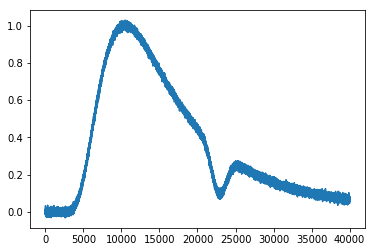

In [26]:
sample_data = np.array([generate_spectrum(*sample_prior())])[:, :, np.newaxis]
plt.plot(sample_data[0, :, 0])

In [43]:
sample_data = test_data_init[4:5, :, :]

In [50]:
latent_rep = sess.run(m.encode(m.X), feed_dict={m.X: sample_data})
spectrum = sess.run(m.decode(m.encode(m.X)), feed_dict={m.X: sample_data})

creating revnet level 0 (?, 10000, 4)
actnorm_scale (?, 10000, 4) (1, 1, 4) 10000
splitting z (?, 10000, 4)
creating revnet level 1 (?, 5000, 4)
actnorm_scale (?, 5000, 4) (1, 1, 4) 5000
splitting z (?, 5000, 4)
creating revnet level 2 (?, 2500, 4)
actnorm_scale (?, 2500, 4) (1, 1, 4) 2500
splitting z (?, 2500, 4)
creating revnet level 3 (?, 1250, 4)
actnorm_scale (?, 1250, 4) (1, 1, 4) 1250
splitting z (?, 1250, 4)
creating revnet level 4 (?, 625, 4)
actnorm_scale (?, 625, 4) (1, 1, 4) 625
creating revnet level 0 (?, 10000, 4)
actnorm_scale (?, 10000, 4) (1, 1, 4) 10000
splitting z (?, 10000, 4)
creating revnet level 1 (?, 5000, 4)
actnorm_scale (?, 5000, 4) (1, 1, 4) 5000
splitting z (?, 5000, 4)
creating revnet level 2 (?, 2500, 4)
actnorm_scale (?, 2500, 4) (1, 1, 4) 2500
splitting z (?, 2500, 4)
creating revnet level 3 (?, 1250, 4)
actnorm_scale (?, 1250, 4) (1, 1, 4) 1250
splitting z (?, 1250, 4)
creating revnet level 4 (?, 625, 4)
actnorm_scale (?, 625, 4) (1, 1, 4) 625
actnorm_

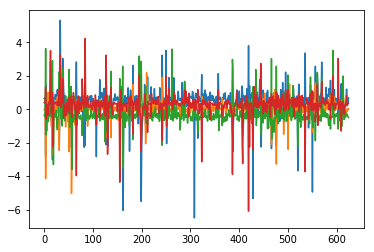

In [45]:
plt.plot(latent_rep[0, :, 0])
plt.plot(latent_rep[0, :, 1])
plt.plot(latent_rep[0, :, 2])
plt.plot(latent_rep[0, :, 3])

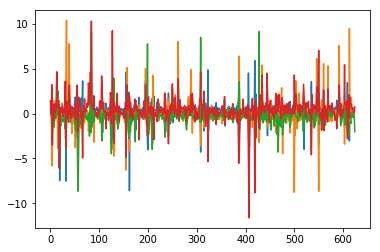

In [51]:
plt.plot(latent_rep[0, :, 0])
plt.plot(latent_rep[0, :, 1])
plt.plot(latent_rep[0, :, 2])
plt.plot(latent_rep[0, :, 3])

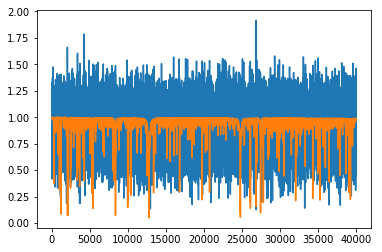

In [47]:
plt.plot(np.squeeze(spectrum))
plt.plot(np.squeeze(sample_data))

(-0.5, 1.5)

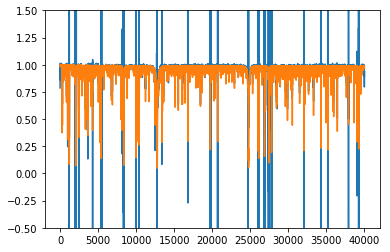

In [53]:
plt.plot(np.squeeze(spectrum))
plt.plot(np.squeeze(sample_data))
plt.ylim(-.5, 1.5)